In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import Flowers102
from torchvision.transforms import v2
import matplotlib.pyplot as plt

In [2]:
# Workout actual mean and std of dataset
transform = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True),])

dataset = Flowers102(root='', split='train', transform=transform, download=True)

# R, G, B
channel_sum = torch.zeros(3)
channel_sum_squared = torch.zeros(3)
count = 0

for img, _ in dataset:
    channel_sum += torch.mean(img, dim=(1, 2))
    channel_sum_squared += torch.mean(img ** 2, dim=(1, 2))
    count += 1

mean = channel_sum / count
std = torch.sqrt(channel_sum_squared / count - mean ** 2)

print("Mean:", mean)
print("Std:", std)

Mean: tensor([0.4330, 0.3819, 0.2964])
Std: tensor([0.2952, 0.2473, 0.2742])


In [3]:
train_transform = v2.Compose([
		 v2.ToImage(),
		 v2.RandomResizedCrop(size=(224, 224), antialias=True),
		 v2.RandomHorizontalFlip(),
		 v2.RandomVerticalFlip(),
		 v2.ToDtype(torch.float32, scale=True),
		 v2.Normalize(mean=mean.numpy(), std=std.numpy()),
])

transform = v2.Compose([
		 v2.ToImage(),
		 v2.Resize((224, 224)),
		 v2.ToDtype(torch.float32, scale=True),
		 v2.Normalize(mean=mean.numpy(), std=std.numpy()),

])

In [4]:
training_data = Flowers102( root='', split='train', transform=train_transform, download=True)
testing_data = Flowers102(root='',split='test',transform=transform,download=True)
evaluation_data = Flowers102(root='',split='val',transform=transform,download=True)

In [5]:
print('Training data has {} instances'.format(len(training_data)))
print('Evaluation data has {} instances'.format(len(evaluation_data)))
print('Testing data has {} instances'.format(len(testing_data)))

Training data has 1020 instances
Evaluation data has 1020 instances
Testing data has 6149 instances


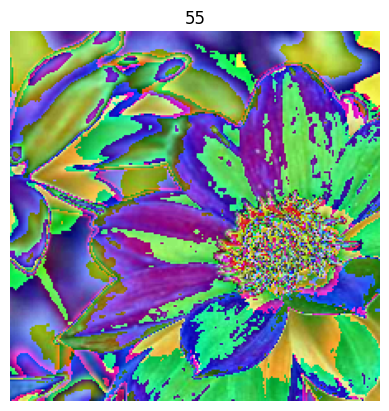

In [6]:
img, label = training_data[555] # just a random instance to see how the data has been normalised
np_img = img.permute(1, 2, 0).numpy()
plt.title(label)
plt.imshow((np_img * 255).astype('uint8'))
plt.axis('off')
plt.show()

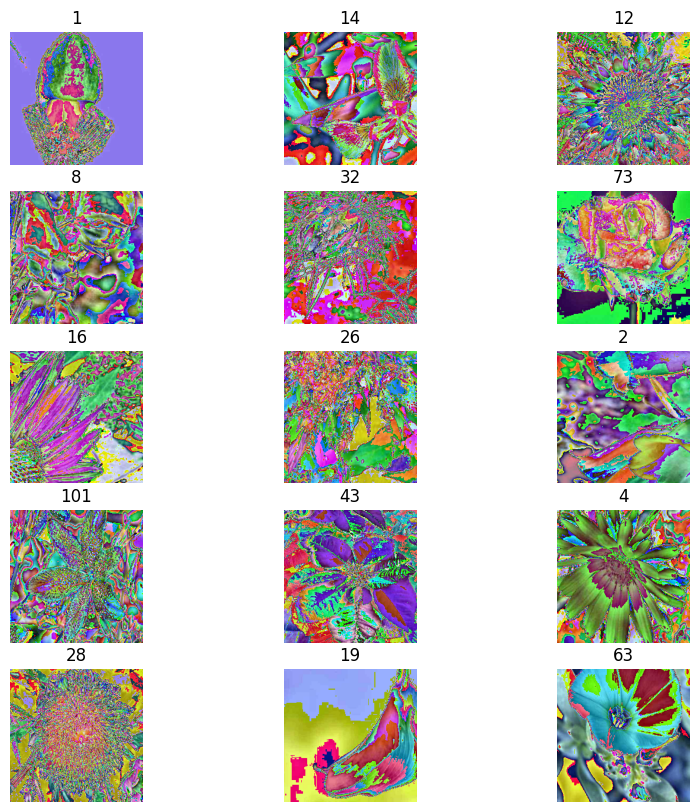

In [7]:
figure = plt.figure(figsize=(10, 10))
cols, rows = 3, 5
for i in range(1, cols * rows + 1):
	sample_idx = torch.randint(len(training_data), size=(1,)).item()
	img, label = training_data[sample_idx]

	np_img = img.permute(1, 2, 0).numpy()
	figure.add_subplot(rows, cols, i)
	plt.title(label)
	plt.imshow((np_img * 255).astype('uint8'))
	plt.axis('off')
plt.show()

In [8]:
# transform simple NN into a CNN
class FlowerClassifier(nn.Module):
	def __init__(self):
			super(FlowerClassifier, self).__init__()
			self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
			self.bn1 = nn.BatchNorm2d(64)
			self.relu = nn.ReLU()
			self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
			self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
			self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)

			self.flatten = nn.Flatten()
			self.fc1 = nn.Linear(256 * 28 * 28, 102)

	def forward(self, x):
			x = self.pool(self.relu(self.bn1(self.conv1(x))))
			x = self.pool(self.relu(self.conv2(x)))
			x = self.pool(self.relu(self.conv3(x)))
			x = self.flatten(x)
			x = self.fc1(x)
			return F.log_softmax(x, dim=1)

In [9]:
training_loader = DataLoader(training_data, batch_size=128, shuffle=True)
evaluation_loader = DataLoader(evaluation_data, batch_size=128, shuffle=False)

In [10]:
# Check if CUDA is available
if torch.cuda.is_available():
	print("CUDA is available!")
	device = torch.device("cuda")
else:
	print("CUDA is not available. The model will use CPU.")
	device = torch.device("cpu")

CUDA is available!


In [11]:
def train(model, training_loader, evaluation_loader, criterion, optimizer, epochs=10):
	train_losses = []
	eval_losses = []
	eval_accuracies = []
	for epoch in range(epochs):
		model.train()
		training_loss = 0.0
		for inputs, labels in training_loader:
			inputs, labels = inputs.to(device), labels.to(device)
			optimizer.zero_grad()
			outputs = model(inputs)
			loss = criterion(outputs, labels)
			loss.backward()
			optimizer.step()
			training_loss += loss.item() * inputs.size(0)

		training_loss /= len(training_loader.dataset)
		train_losses.append(training_loss)

		model.eval()
		evaluation_loss = 0.0
		correct = 0
		total = 0
		with torch.no_grad():
			for inputs, labels in evaluation_loader:
				inputs, labels = inputs.to(device), labels.to(device)
				outputs = model(inputs)
				loss = criterion(outputs, labels)
				evaluation_loss += loss.item() * inputs.size(0)
				_, predicted = torch.max(outputs, 1)
				total += labels.size(0)
				correct += (predicted == labels).sum().item()

		evaluation_loss /= len(evaluation_loader.dataset)
		evaluation_accuracy = correct / total
		eval_losses.append(evaluation_loss)
		eval_accuracies.append(evaluation_accuracy)

		print(
			f'Epoch {epoch + 1}/{epochs}, Training Loss: {training_loss:.4f}, Evaluation Loss: {evaluation_loss:.4f}, Val Accuracy: {evaluation_accuracy:.4f}')

# Plotting the training and evaluation losses
	plt.figure(figsize=(8, 4))
	plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
	plt.plot(range(1, epochs + 1), eval_losses, label='Evaluation Loss')
	plt.xlabel('Epochs')
	plt.ylabel('Loss')
	plt.title('Training and Evaluation Losses')
	plt.legend()
	plt.show()

# Plotting the evaluation accuracy
	plt.figure(figsize=(8, 4))
	plt.plot(range(1, epochs + 1), eval_accuracies, label='Validation Accuracy')
	plt.xlabel('Epochs')
	plt.ylabel('Accuracy')
	plt.title('Validation Accuracy')
	plt.legend()
	plt.show()


Epoch 1/30, Training Loss: 4.8727, Evaluation Loss: 4.4469, Val Accuracy: 0.0461
Epoch 2/30, Training Loss: 4.1587, Evaluation Loss: 4.0795, Val Accuracy: 0.0990
Epoch 3/30, Training Loss: 3.6909, Evaluation Loss: 3.7049, Val Accuracy: 0.1529
Epoch 4/30, Training Loss: 3.4378, Evaluation Loss: 3.5297, Val Accuracy: 0.1588
Epoch 5/30, Training Loss: 3.2986, Evaluation Loss: 3.3965, Val Accuracy: 0.1824
Epoch 6/30, Training Loss: 3.1553, Evaluation Loss: 3.3501, Val Accuracy: 0.1882
Epoch 7/30, Training Loss: 3.0451, Evaluation Loss: 3.2915, Val Accuracy: 0.2225
Epoch 8/30, Training Loss: 2.9076, Evaluation Loss: 3.2452, Val Accuracy: 0.2412
Epoch 9/30, Training Loss: 2.7953, Evaluation Loss: 3.1939, Val Accuracy: 0.2363
Epoch 10/30, Training Loss: 2.6824, Evaluation Loss: 3.1085, Val Accuracy: 0.2588
Epoch 11/30, Training Loss: 2.5425, Evaluation Loss: 3.0942, Val Accuracy: 0.2833
Epoch 12/30, Training Loss: 2.4842, Evaluation Loss: 3.0685, Val Accuracy: 0.2696
Epoch 13/30, Training Los

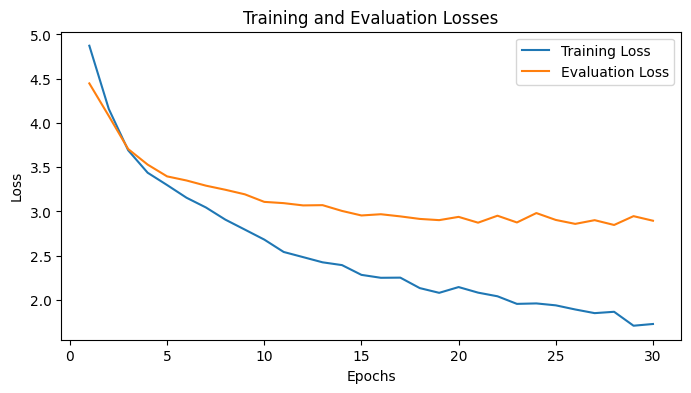

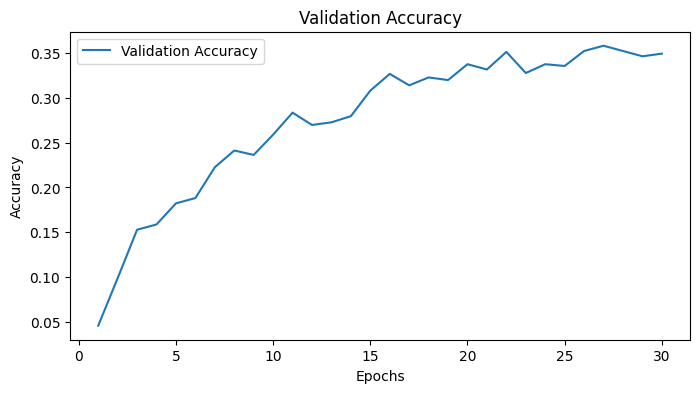

In [12]:
model = FlowerClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

train(model, training_loader, evaluation_loader, criterion, optimizer, epochs=30)

Evaluation Loss: 2.8954, Accuracy: 0.3490
There were 664 images predicted incorrectly by the model.


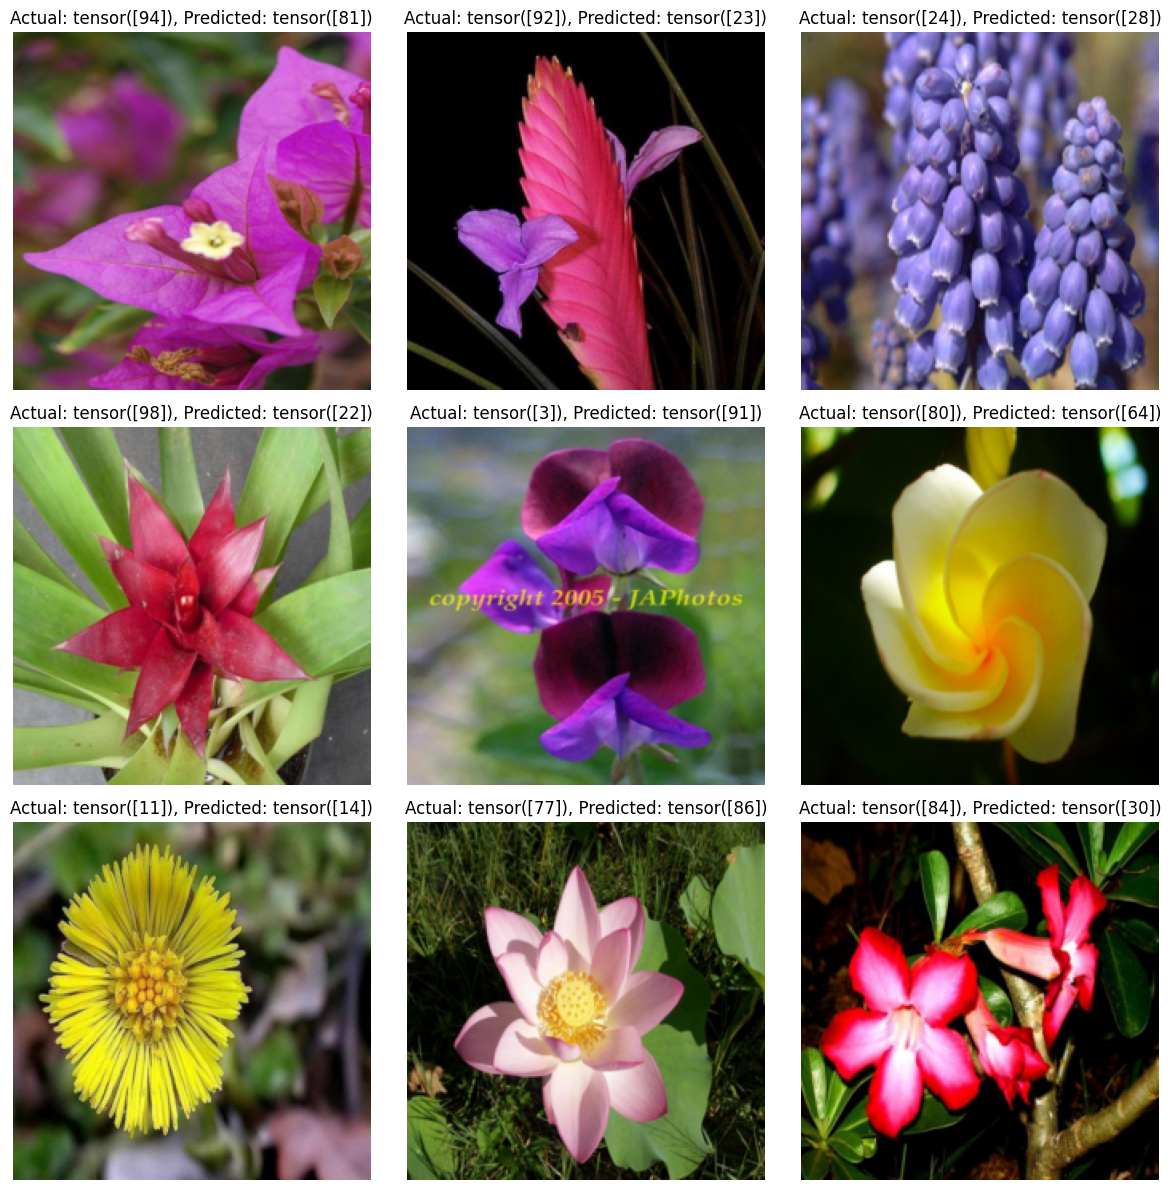

In [13]:
import random

def evaluate(model, evaluation_loader, criterion):
    model.eval()
    evaluation_loss = 0.0
    correct = 0
    total = 0
    misclassified_images = []

    with torch.no_grad():
        for inputs, labels in evaluation_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            evaluation_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            misclassified_inds = (predicted != labels).nonzero()
            for mis_ind in misclassified_inds:
                mis_img = inputs[mis_ind].cpu()
                mis_label = labels[mis_ind].cpu()
                mis_pred = predicted[mis_ind].cpu()
                misclassified_images.append((mis_img, mis_label, mis_pred))

    evaluation_loss /= len(evaluation_loader.dataset)
    evaluation_accuracy = correct / total

    print(f'Evaluation Loss: {evaluation_loss:.4f}, Accuracy: {evaluation_accuracy:.4f}')

    return misclassified_images

misclassified_images = evaluate(model, evaluation_loader, criterion)
print(f'There were {len(misclassified_images)} images predicted incorrectly by the model.')

# Plot misclassified images
figure = plt.figure(figsize=(12, 12))
cols, rows = 3, 3
selected_indices = random.sample(range(len(misclassified_images)), min(cols * rows, len(misclassified_images)))
for i, index in enumerate(selected_indices, 1):
    mis_img, mis_label, mis_pred = misclassified_images[index]
    np_img = (mis_img.squeeze().permute(1, 2, 0).numpy() * std.numpy() + mean.numpy()).clip(0, 1)
    figure.add_subplot(rows, cols, i)
    plt.title(f'Actual: {mis_label}, Predicted: {mis_pred}')
    plt.imshow((np_img * 255).astype('uint8'))
    plt.axis('off')

plt.tight_layout()
plt.show()